### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for Atari [Kung-Fu Master](https://gym.openai.com/envs/KungFuMaster-v0/) that uses a recurrent neural net.

![https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png](https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png)

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # https://github.com/yandexdataschool/Practical_RL/issues/256
    !pip uninstall tensorflow --yes
    !pip uninstall keras --yes
    !pip install tensorflow-gpu==1.13.1
    !pip install keras==2.2.4
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week08_pomdp/atari_util.py
        
        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 345.2MB 45kB/s 
     |████████████████████████████████| 368kB 45.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 3.2MB 20.6MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
     |████████████████████████████████| 317kB 1.8MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
Selecting previously unselected package xvfb.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.

In [2]:
"""
A thin wrapper for openAI gym environments that maintains a set of parallel games and has a method to generate
interaction sessions given agent one-step applier function.
"""

import numpy as np

# A whole lot of space invaders


class EnvPool(object):
    def __init__(self, actor, critic, make_env, n_parallel_games=1):
        """
        A special class that handles training on multiple parallel sessions
        and is capable of some auxilary actions like evaluating agent on one game session (See .evaluate()).

        :param agent: Agent which interacts with the environment.
        :param make_env: Factory that produces environments OR a name of the gym environment.
        :param n_games: Number of parallel games. One game by default.
        :param max_size: Max pool size by default (if appending sessions). By default, pool is not constrained in size.
        """
        # Create atari games.
        self.actor  = actor
        self.critic = critic
        self.make_env = make_env
        self.envs = [self.make_env() for _ in range(n_parallel_games)]

        # Initial observations.
        self.prev_observations = [env.reset() for env in self.envs]

        # Agent memory variables (if you use recurrent networks).
        self.prev_memory_states_actor  = actor.get_initial_state(n_parallel_games)
        self.prev_memory_states_critic = critic.get_initial_state(n_parallel_games)

        # Whether particular session has just been terminated and needs
        # restarting.
        self.just_ended = [False] * len(self.envs)


    def interact(self, n_steps=100, verbose=False):
        """Generate interaction sessions with ataries (openAI gym atari environments)
        Sessions will have length n_steps. Each time one of games is finished, it is immediately getting reset
        and this time is recorded in is_alive_log (See returned values).

        :param n_steps: Length of an interaction.
        :returns: observation_seq, action_seq, reward_seq, is_alive_seq
        :rtype: a bunch of tensors [batch, tick, ...]
        """

        def env_step(i, action):
            if not self.just_ended[i]:
                new_observation, cur_reward, is_done, info = self.envs[i].step(action)
                if is_done:
                    # Game ends now, will finalize on next tick.
                    self.just_ended[i] = True

                # note: is_alive=True in any case because environment is still
                # alive (last tick alive) in our notation.
                return new_observation, cur_reward, True, info
            else:
                # Reset environment, get new observation to be used on next
                # tick.
                new_observation = self.envs[i].reset()

                # Reset memory for new episode.
                initial_memory_state_actor  = self.actor.get_initial_state(batch_size=1)
                initial_memory_state_critic = self.critic.get_initial_state(batch_size=1)

                for m_i in range(len(new_memory_states_actor)):
                    new_memory_states_actor[m_i][i]  = initial_memory_state_actor[m_i][0]

                for m_i in range(len(new_memory_states_critic)):
                    new_memory_states_critic[m_i][i] = initial_memory_state_critic[m_i][0]

                if verbose:
                    print("env %i reloaded" % i)

                self.just_ended[i] = False

                return new_observation, 0, False, {'end': True}

        history_log = []
        
        last_prev_mem_state_actor  = self.prev_memory_states_actor
        last_prev_mem_state_critic = self.prev_memory_states_critic

        for i in range(n_steps):
            new_memory_states_actor, logits = self.actor.step(self.prev_memory_states_actor, 
                                                              self.prev_observations)
            sampled_actions = self.actor.sample_actions(logits)

            new_memory_states_critic, state_values = self.critic.step(self.prev_memory_states_critic,
                                                                      self.prev_observations)

            new_observations, cur_rewards, is_alive, infos = zip(
                *map(env_step, range(len(self.envs)), sampled_actions))
            
            
            # Append data tuple for this tick.
            history_log.append(
                (self.prev_observations, sampled_actions, cur_rewards, is_alive))

            
            self.prev_observations  = new_observations

            last_prev_mem_state_actor  = self.prev_memory_states_actor
            last_prev_mem_state_critic = self.prev_memory_states_critic

            self.prev_memory_states_actor  = new_memory_states_actor
            self.prev_memory_states_critic = new_memory_states_critic
            
            

        # add last observation
        #dummy_actions = [0] * len(self.envs)
        #dummy_rewards = [0] * len(self.envs)
        #dummy_mask = [1] * len(self.envs)
        #history_log.append(
        #    (self.prev_observations,
        #     dummy_actions,
        #     dummy_rewards,
        #     dummy_mask))

        # cast to numpy arrays, 
        # transpose from [time, batch, ...] to [batch, time, ...]
        history_log = [
            np.array(tensor).swapaxes(0, 1)
            for tensor in zip(*history_log)
        ]
        observation_seq, action_seq, reward_seq, is_alive_seq = history_log

        return observation_seq, action_seq, reward_seq, is_alive_seq, last_prev_mem_state_critic


In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

For starters, let's take a look at the game itself:

* Image resized to 42x42 and converted to grayscale to run faster
* Agent sees last 4 frames of game to account for object velocity

In [4]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


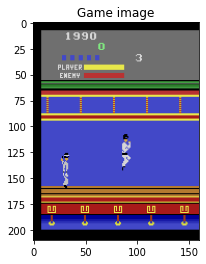

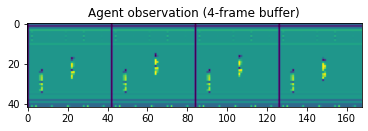

In [5]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

### Simple agent for fully-observable MDP

Here's a code for an agent that only uses feedforward layers. Please read it carefully: you'll have to extend it later!

In [6]:
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten
from tensorflow.nn.rnn_cell import LSTMCell, LSTMStateTuple


tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [7]:
class SimpleRecurrentAgent_Q:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
             # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (4, 4), strides=(2, 2), activation='relu')
            self.conv1 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')
            self.conv2 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')

            self.flatten = Flatten()
            self.hid     = Dense(128, activation='relu')
            
            # Actor: pi(a|s)
            self.logits  = Dense(n_actions)
            
            # Recurrent Layer
            self.hid_size  = 128
            self.rnn0 = LSTMCell(self.hid_size, state_is_tuple = True)

            # prepare a graph for agent step
            initial_state_c = tf.placeholder(dtype=tf.float32, 
                                             shape=[None, self.hid_size],
                                             name="init_state_c")
            
            initial_state_h = tf.placeholder(dtype=tf.float32, 
                                             shape=[None, self.hid_size],
                                             name="init_state_h")
            
            self.prev_state_placeholder = LSTMStateTuple(initial_state_c, initial_state_h)

            self.obs_t = tf.placeholder(tf.float32, [None, ] + list(obs_shape))

            self.next_state, self.agent_outputs = self.symbolic_step(self.prev_state_placeholder,
                                                                     self.obs_t)
            
            self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                               scope = name)
            
            print("\n" + "Model Summary (" + name + ")")
            for t in self.variables:
                print(t)
            


    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)
        
        # Apply recurrent neural net for one step here.
        # The recurrent cell should take the last feedforward dense layer as input.
        batch_ones = tf.ones(tf.shape(obs_t)[0])
        new_out, new_state_ch = tf.nn.dynamic_rnn(self.rnn0, nn[:,None],
                                                  initial_state = prev_state,
                                                  sequence_length = batch_ones)
        
        logits = self.logits(new_out[:,0])

        return new_state_ch, logits


    def get_initial_state(self, batch_size):
        # LSTMStateTuple([batch_size x hid_size], [batch_size x hid_size]]
        a = np.zeros([batch_size, self.hid_size], dtype=np.float32)
        return LSTMStateTuple(a, a)


    # Instantiation
    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        
        feed_dict = {self.obs_t: obs_t,
                     self.prev_state_placeholder: prev_state}
        
        return sess.run([self.next_state, self.agent_outputs], feed_dict)


    def sample_actions(self, logits):
        """pick actions given numeric agent outputs (np arrays)"""
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

        return [np.random.choice(len(p), p=p) for p in policy]



In [8]:
class SimpleRecurrentAgent_V:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
             # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (4, 4), strides=(2, 2), activation='relu')
            self.conv1 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')
            self.conv2 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')

            self.flatten = Flatten()
            self.hid     = Dense(128, activation='relu')
            
            # Critic: State Values
            self.state_value = Dense(1)
            
            # Recurrent Layer
            self.hid_size  = 128
            self.rnn0 = LSTMCell(self.hid_size, state_is_tuple = True)

            # prepare a graph for agent step
            initial_state_c = tf.placeholder(dtype=tf.float32, 
                                             shape=[None, self.hid_size],
                                             name="init_state_c")
            
            initial_state_h = tf.placeholder(dtype=tf.float32, 
                                             shape=[None, self.hid_size],
                                             name="init_state_h")
            
            self.prev_state_placeholder = LSTMStateTuple(initial_state_c, initial_state_h)

            self.obs_t = tf.placeholder(tf.float32, [None, ] + list(obs_shape))

            self.next_state, self.agent_outputs = self.symbolic_step(self.prev_state_placeholder,
                                                                     self.obs_t)
            
            self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                               scope = name)
            
            print("\n" + "Model Summary (" + name + ")")
            for t in self.variables:
                print(t)
            


    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)
        
        # Apply recurrent neural net for one step here.
        # The recurrent cell should take the last feedforward dense layer as input.
        batch_ones = tf.ones(tf.shape(obs_t)[0])
        new_out, new_state_ch = tf.nn.dynamic_rnn(self.rnn0, nn[:,None],
                                                  initial_state = prev_state,
                                                  sequence_length = batch_ones)
        
        state_value = self.state_value(new_out[:,0])

        return new_state_ch, state_value


    def get_initial_state(self, batch_size):
        # LSTMStateTuple([batch_size x hid_size], [batch_size x hid_size]]
        a = np.zeros([batch_size, self.hid_size], dtype=np.float32)
        return LSTMStateTuple(a, a)


    # Instantiation
    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        
        feed_dict = {self.obs_t: obs_t,
                     self.prev_state_placeholder: prev_state}
        
        return sess.run([self.next_state, self.agent_outputs], feed_dict)


    def get_state_values(self, prev_state, obs_t):
        sess = tf.get_default_session()
        
        feed_dict = {self.obs_t: obs_t,
                     self.prev_state_placeholder: prev_state}
        
        return sess.run(self.agent_outputs, feed_dict)





In [9]:
n_parallel_games = 10
rollout_length   = 25
gamma = 0.99

actor  = SimpleRecurrentAgent_Q('actor',  obs_shape, n_actions)
critic = SimpleRecurrentAgent_V('critic', obs_shape, n_actions)

sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.

Model Summary (actor)
<tf.Variable 'actor/conv2d_1/kernel:0' shape=(4, 4, 4, 32) dtype=float32_ref>
<tf.Variable 'actor/conv2d_1/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'actor/conv2d_2/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>
<tf.Variable 'actor/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'actor/conv2d_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>
<tf.Variable 'actor/conv2d_3/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'actor/dense_1/kernel:0' shape=(3136, 128) dtype=float32_ref>
<tf.Variable 'actor/dense_1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'actor/rnn/lstm_cell/kernel:0' shape

In [10]:
state = [env.reset()]
_, logits       = actor.step(actor.get_initial_state(1), state)
_, state_values = critic.step(critic.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", state_values)

action logits:
 [[-0.01165732 -0.01234715  0.00920098  0.00207483 -0.00184921 -0.00266627
   0.00050533  0.00414065  0.00437399  0.00013939 -0.00143254 -0.0081718
   0.00056811  0.00049527]]
state values:
 [[-0.00864113]]


### Let's play!
Let's build a function that measures agent's average reward.

In [11]:
def evaluate(actor, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = actor.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = actor.step(prev_memories, 
                                                observation[None, ...])
            action = actor.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [12]:
#import gym.wrappers

#with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
#    rewards = evaluate(actor, env_monitor, n_games=3)

#print(rewards)

In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

#from pathlib import Path
#from IPython.display import HTML

#video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

#HTML("""
#<video width="640" height="480" controls>
#  <source src="{}" type="video/mp4">
#</video>
#""".format(video_names[-1]))  # You can also try other indices

### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://s7.postimg.cc/4y36s2b2z/env_pool.png)

In [14]:
# TARGET AGENT is used to sample
pool = EnvPool(actor, critic, make_env, n_parallel_games)

In [15]:
# for each of n_parallel_games, take "rollout_length" steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask, last_prev_mem_state_critic = pool.interact(rollout_length)

In [16]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)
print("Last Previous Memory State: ", (last_prev_mem_state_critic[0].shape, last_prev_mem_state_critic[1].shape))

Actions shape: (10, 25)
Rewards shape: (10, 25)
Mask shape: (10, 25)
Observations shape:  (10, 25, 42, 42, 4)
Last Previous Memory State:  ((10, 128), (10, 128))


# Actor-critic objective

Here we define a loss function that uses rollout above to train advantage actor-critic agent.


Our loss consists of three components:

* __The policy "loss"__
 $$ \hat J = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * This function has no meaning in and of itself, but it was built such that
  * $ \nabla \hat J = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * Therefore if we __maximize__ J_hat with gradient descent we will maximize expected reward
  
  
* __The value "loss"__
  $$ L_{td} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Ye Olde TD_loss from q-learning and alike
  * If we minimize this loss, V(s) will converge to $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $


* __Entropy Regularizer__
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * If we __maximize__ entropy we discourage agent from predicting zero probability to actions
  prematurely (a.k.a. exploration)
  
  
So we optimize a linear combination of $L_{td} - \hat J -H$


__One more thing:__ since we train on T-step rollouts, we can use N-step formula for advantage for free:
  * At the last step, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s) $
  * One step earlier, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s) $
  * Et cetera, et cetera. This way agent starts training much faster since it's estimate of A(s,a) depends less on his (imperfect) value function and more on actual rewards. There's also a [nice generalization](https://arxiv.org/abs/1506.02438) of this.


__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [17]:
# Updatable agent

# [batch, time, h, w, c]
observations_ph       = tf.placeholder('float32', [None, None,] + list(obs_shape))
sampled_actions_ph    = tf.placeholder('int32',   (None, None,))
mask_ph               = tf.placeholder('float32', (None, None,))

rewards_ph            = tf.placeholder('float32', (None, None,))
cumulative_rewards_ph = tf.placeholder('float32', (None, None,))


init_state_actor_ph  = actor.prev_state_placeholder
init_state_critic_ph = critic.prev_state_placeholder

# get new_state, (actor->logits, critic->state_value)
next_state_actor, logits = actor.symbolic_step(init_state_actor_ph,
                                               observations_ph[:, 0])

next_state_critic, state_values = critic.symbolic_step(init_state_critic_ph,
                                                       observations_ph[:, 0])

def f(stack, obs_t):
    init_state_actor, init_state_critic = stack[0], stack[1]
    next_state_actor, logits = actor.symbolic_step(init_state_actor, obs_t)
    next_state_critic, state_values = critic.symbolic_step(init_state_critic, obs_t)
    return [next_state_actor, next_state_critic, logits, state_values]

[next_state_seq_actor, next_state_seq_critic, logits_seq, state_values_seq] = tf.scan(
    f,
    initializer = [init_state_actor_ph, init_state_critic_ph, logits, state_values],
    elems = tf.transpose(observations_ph, [1, 0, 2, 3, 4])
    # elem.shape = [time, batch, h, w, c]
)
print(next_state_seq_actor)
print(next_state_seq_critic)
print(logits_seq)
print(state_values_seq)


# from [time, batch] back to [batch, time]
logits_seq = tf.transpose(logits_seq, [1, 0, 2])
state_values_seq = tf.transpose(state_values_seq, [1, 0, 2])

next_state_seq_actor  = [tf.transpose(tensor, [1, 0] + list(range(2, tensor.shape.ndims))) 
                         for tensor in next_state_seq_actor]
next_state_seq_critic = [tf.transpose(tensor, [1, 0] + list(range(2, tensor.shape.ndims))) 
                         for tensor in next_state_seq_critic]

print(logits_seq)
print(state_values_seq)
print(next_state_seq_actor)
print(next_state_seq_critic)

LSTMStateTuple(c=<tf.Tensor 'scan/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 128) dtype=float32>, h=<tf.Tensor 'scan/TensorArrayStack_1/TensorArrayGatherV3:0' shape=(?, ?, 128) dtype=float32>)
LSTMStateTuple(c=<tf.Tensor 'scan/TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?, ?, 128) dtype=float32>, h=<tf.Tensor 'scan/TensorArrayStack_3/TensorArrayGatherV3:0' shape=(?, ?, 128) dtype=float32>)
Tensor("scan/TensorArrayStack_4/TensorArrayGatherV3:0", shape=(?, ?, 14), dtype=float32)
Tensor("scan/TensorArrayStack_5/TensorArrayGatherV3:0", shape=(?, ?, 1), dtype=float32)
Tensor("transpose_1:0", shape=(?, ?, 14), dtype=float32)
Tensor("transpose_2:0", shape=(?, ?, 1), dtype=float32)
[<tf.Tensor 'transpose_3:0' shape=(?, ?, 128) dtype=float32>, <tf.Tensor 'transpose_4:0' shape=(?, ?, 128) dtype=float32>]
[<tf.Tensor 'transpose_5:0' shape=(?, ?, 128) dtype=float32>, <tf.Tensor 'transpose_6:0' shape=(?, ?, 128) dtype=float32>]


In [18]:
# Updatable agent

# actor-critic losses
# actor  -> logits, with shape: [batch, time, n_actions]
# critic -> states, with shape: [batch, time, 1]
r = 0

logprobs_seq = tf.nn.log_softmax(logits_seq)
logp_actions = tf.reduce_sum(logprobs_seq * tf.one_hot(sampled_actions_ph, n_actions),
                             axis=-1)[:, r:-1]

current_rewards = rewards_ph[:, r:-1] / 100.
current_state_values = state_values_seq[:, r:-1, 0]

next_state_values = state_values_seq[:, r+1:, 0] * mask_ph[:, r:-1]


# policy gradient
# compute 1-step advantage using current_rewards, current_state_values and next_state_values
# have to manually adjust in the code for "r" the right size of cumulative_rewards_ph
advantage = cumulative_rewards_ph - current_state_values
assert advantage.shape.ndims == 2

# compute policy entropy given logits_seq. Mind the sign!
policy  = tf.nn.softmax(logits_seq, axis=-1)
entropy = - tf.reduce_sum(policy * logprobs_seq, axis=-1)
assert entropy.shape.ndims == 2

actor_loss = - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage))
actor_loss -= 0.001 * tf.reduce_mean(entropy)

# Prepare Temporal Difference error (States)
target_state_values = (current_rewards + gamma * next_state_values + cumulative_rewards_ph) / 2 
critic_loss = tf.reduce_mean(
    (current_state_values - tf.stop_gradient(target_state_values))**2)

train_step = tf.train.AdamOptimizer(1e-5).minimize(actor_loss + critic_loss)

In [19]:
sess.run(tf.global_variables_initializer())

# Train 

just run train step and see if agent learns any better

In [20]:
def acc_rewards(rewards, last_state_values, r=10, gamma=0.99):
        # rewards at each step [batch, time]
        # in a phase, last previous memory state [batch, state_dim]
        # discount for reward
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    curr_rewards = rewards / 100.
    b_size, time = rewards.shape
    
    acc_reward = np.zeros((b_size, time-r-1), dtype='float32')
    acc_reward[:,time-r-2] = last_state_values

    for i in reversed(np.arange(time-r-2)):
        acc_reward[:,i] = curr_rewards[:,i] + gamma * acc_reward[:,i+1]
        
    return acc_reward

In [21]:
def sample_batch(rollout_length=rollout_length):
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask, prev_state_critic = pool.interact(rollout_length)

    last_state_values = critic.get_state_values(prev_state_critic, rollout_obs[:,-1])
    
    rollout_cumulative_rewards = acc_rewards(rollout_rewards, last_state_values[:,0], r)
    
    feed_dict = {
        init_state_actor_ph: actor.get_initial_state(n_parallel_games),
        init_state_critic_ph: critic.get_initial_state(n_parallel_games),
        observations_ph: rollout_obs,
        sampled_actions_ph: rollout_actions,
        mask_ph: rollout_mask,
        rewards_ph: rollout_rewards,
        cumulative_rewards_ph: rollout_cumulative_rewards
    }

    return feed_dict

In [22]:
from IPython.display import clear_output

from tqdm import trange
from pandas import DataFrame

moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []

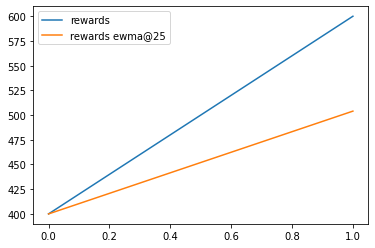

In [ ]:
iters = 2001
for i in range(iters):
    train_step.run(sample_batch())

    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(actor, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=rollout_length), label='rewards ewma@'+str(rollout_length))
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 20000:
            print("Your trainable_agent has just passed the minimum homework threshold")
            break

### "Final" evaluation

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=n_parallel_games)

print("Final mean reward", np.mean(final_rewards))

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

### POMDP setting

The Atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this.

__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

### Now let's train it!

In [ ]:
# A whole lot of your code here: train the new agent with GRU memory.
# - create pool
# - write loss functions and training op
# - train
# You can reuse most of the code with zero to few changes